<a href="https://colab.research.google.com/github/flubberpoof/time-series-lstm-arima/blob/main/LSTM_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consulted Research Paper:

https://ieeexplore.ieee.org/document/10124729

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Data Collection
gold_data = yf.download("GC=F", start="2010-01-01", end="2024-01-01")
# renaming columns to remove the multi-index for easier access
gold_data.columns = [col[0] for col in gold_data.columns]

/tmp/ipython-input-3484542396.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download("GC=F", start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


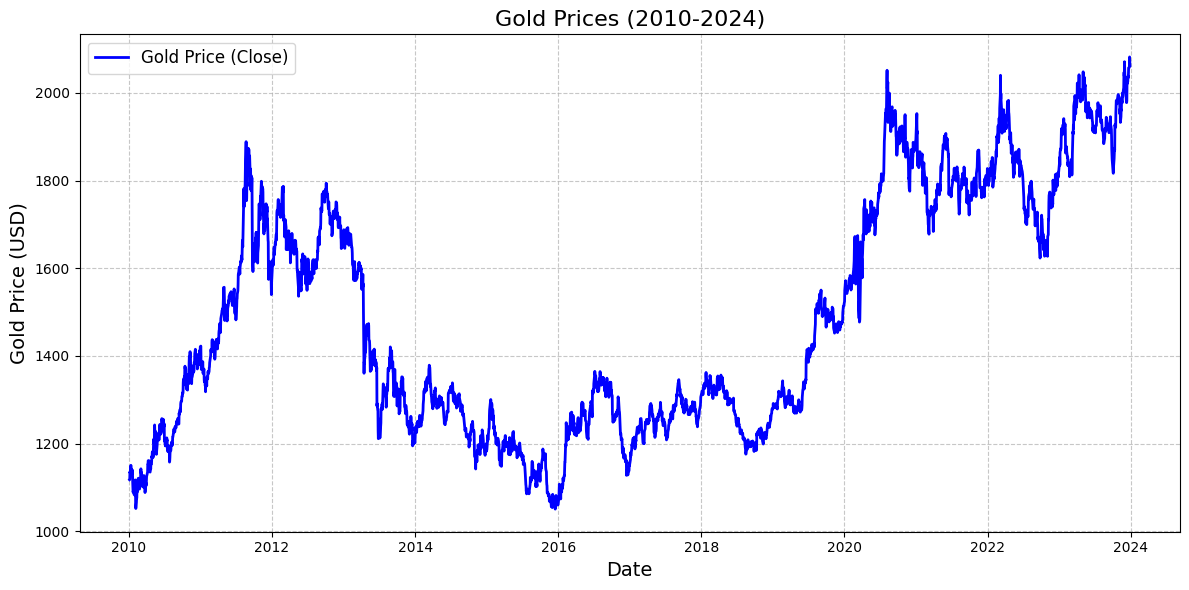

In [ ]:
# Plotting the Close prices
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Close'], label='Gold Price (Close)', color='blue', linewidth=2)

plt.title("Gold Prices (2010-2024)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Gold Price (USD)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Adding Technical Indicators
!pip install ta
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
import pandas as pd

#Simple Moving Average
gold_data['SMA_50'] = SMAIndicator(gold_data['Close'], window=50).sma_indicator()
#Exponential Moving Average
gold_data['EMA_20'] = EMAIndicator(gold_data['Close'], window=20).ema_indicator()

# Relative Strength Indicator
gold_data['RSI'] = RSIIndicator(gold_data['Close'], window=14).rsi()

# Moving Average Convergence Divergence (MACD)
macd = MACD(gold_data['Close'])
gold_data['MACD'] = macd.macd()
gold_data['MACD_Signal'] = macd.macd_signal()

# dropping NA values
gold_data.dropna(inplace=True)


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fa8f823f9e69ca25cd260453eaa433e6edbc605ad7d49e5ce92019d13213750f
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


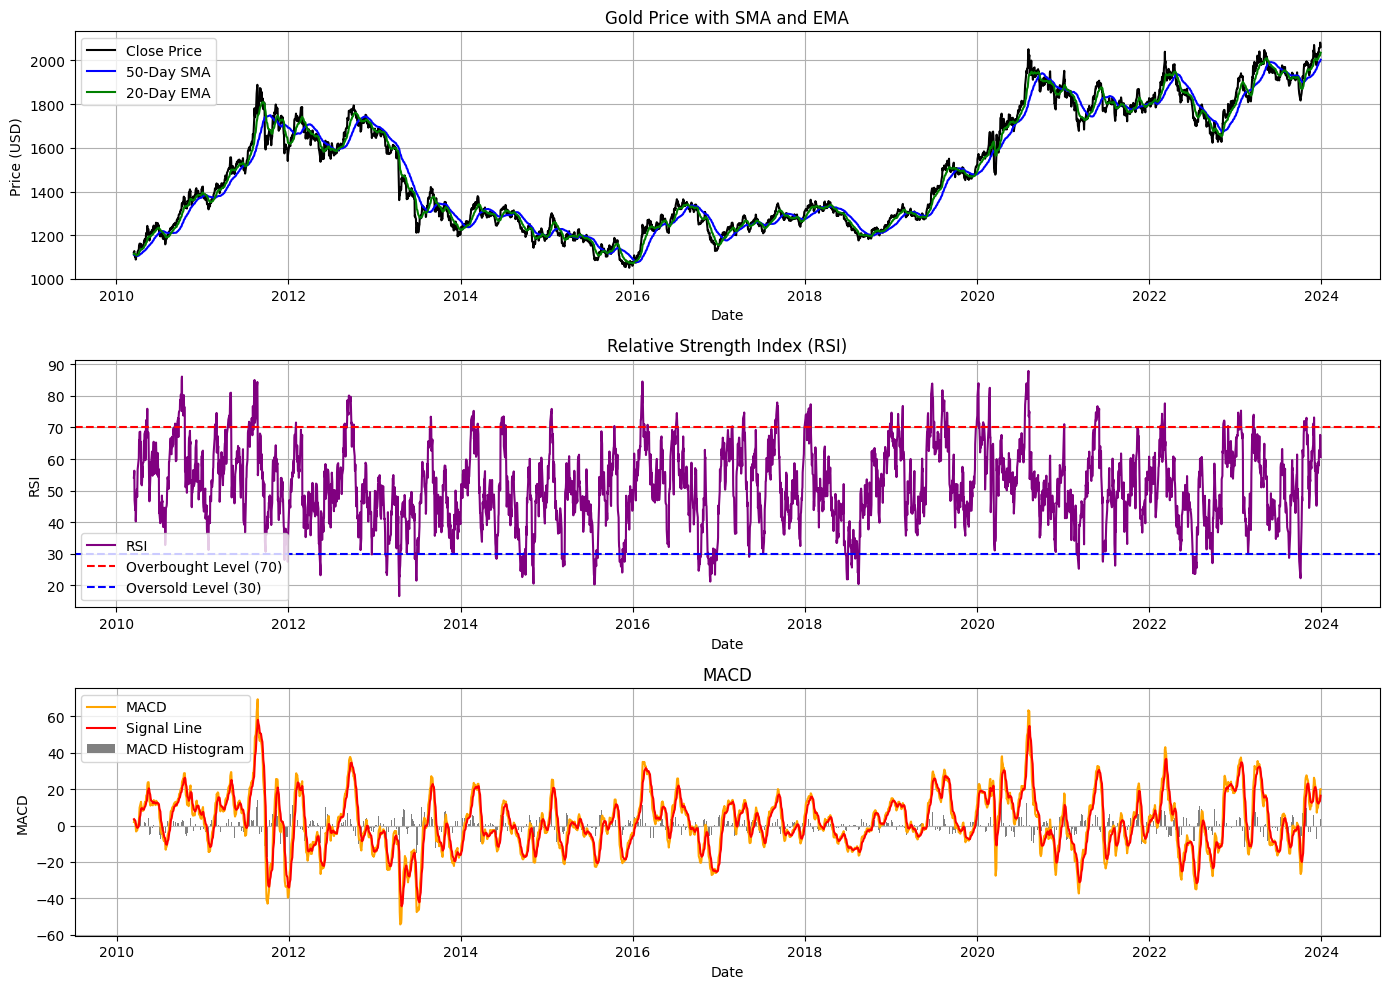

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Main price plot with SMA and EMA
plt.subplot(3, 1, 1)
plt.plot(gold_data.index, gold_data['Close'], label='Close Price', color='black')
plt.plot(gold_data.index, gold_data['SMA_50'], label='50-Day SMA', color='blue')
plt.plot(gold_data.index, gold_data['EMA_20'], label='20-Day EMA', color='green')
plt.title('Gold Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# RSI subplot
plt.subplot(3, 1, 2)
plt.plot(gold_data.index, gold_data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought Level (70)')
plt.axhline(30, linestyle='--', color='blue', label='Oversold Level (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)

# MACD subplot with signal line and histogram
plt.subplot(3, 1, 3)
plt.plot(gold_data.index, gold_data['MACD'], label='MACD', color='orange')
plt.plot(gold_data.index, gold_data['MACD_Signal'], label='Signal Line', color='red')
plt.bar(gold_data.index, gold_data['MACD'] - gold_data['MACD_Signal'], label='MACD Histogram', color='grey')
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The data is scaled using the MinMaxScaler, which ensures that all features fall within a [0, 1] range. The data is structured into sequences of 100 days (each sequence representing the input window), with the corresponding 'close' price as the target for each sequence. An 80-20 split is applied for training and testing data.


In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal']
scaler_features = MinMaxScaler()
gold_data[features] = scaler_features.fit_transform(gold_data[features])

scaler_close = MinMaxScaler()
gold_data['Close'] = scaler_close.fit_transform(gold_data[['Close']])

sequence_length = 100
X, y = [], []

for i in range(sequence_length, len(gold_data)):
    X.append(gold_data[features].iloc[i-sequence_length:i].values)
    y.append(gold_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # should be (samples, 100, features)
print("y shape:", y.shape)  # should be (samples,)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Torch tensors + device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

print("Shape of X_train, X_test:", X_train.shape, X_test.shape)

X shape: (3370, 100, 9)
y shape: (3370,)
Using device: cuda
Shape of X_train, X_test: (2696, 100, 9) (674, 100, 9)


In [ ]:
# Utility Metric Functions
def root_mean_squared_error(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE).

    Args:
        y_true (np.ndarray): True values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: Root mean squared error.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-5):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Args:
        y_true (np.ndarray): True values.
        y_pred (np.ndarray): Predicted values.
        epsilon (float): Small constant to avoid division by zero.

    Returns:
        float: Mean absolute percentage error (in percentage terms).
    """
    non_zero = y_true > epsilon
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100


**Baseline Models**

In [ ]:
# Creating Baseline ARIMA Model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# Inverse-transform training and testing targets back to USD prices for ARIMA
y_train_usd = scaler_close.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_usd = scaler_close.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(y_train_usd)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("The series is stationary (no differencing required).")
else:
    print("The series is not stationary (d>0 likely needed).")

ADF Statistic: -1.3497838440581795
p-value: 0.6060998479413913
The series is not stationary (d>0 likely needed).


In [ ]:
y_train_diff = pd.Series(y_train_usd).diff().dropna()

# ADF test on differenced series
adf_result_diff = adfuller(y_train_diff)
print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])
if adf_result_diff[1] <= 0.05:
    print("Differenced series is stationary → set d=1 in ARIMA.")
else:
    print("Differenced series still not stationary → consider higher d or transformations.")

ADF Statistic (Differenced): -17.460442804396344
p-value (Differenced): 4.600364593253507e-30
✅ Differenced series is stationary → set d=1 in ARIMA.


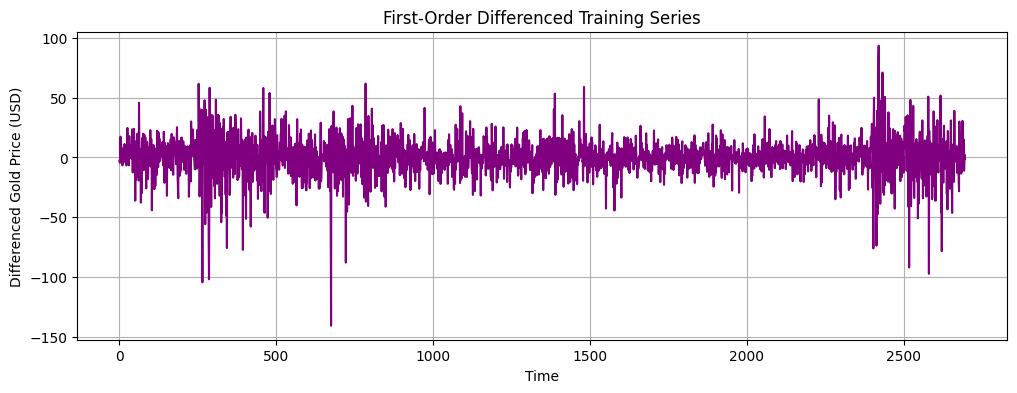

In [ ]:
# Plot differenced series for visualization
plt.figure(figsize=(12, 4))
plt.plot(y_train_diff, color="purple")
plt.title("First-Order Differenced Training Series")
plt.xlabel("Time")
plt.ylabel("Differenced Gold Price (USD)")
plt.grid(True)
plt.show()

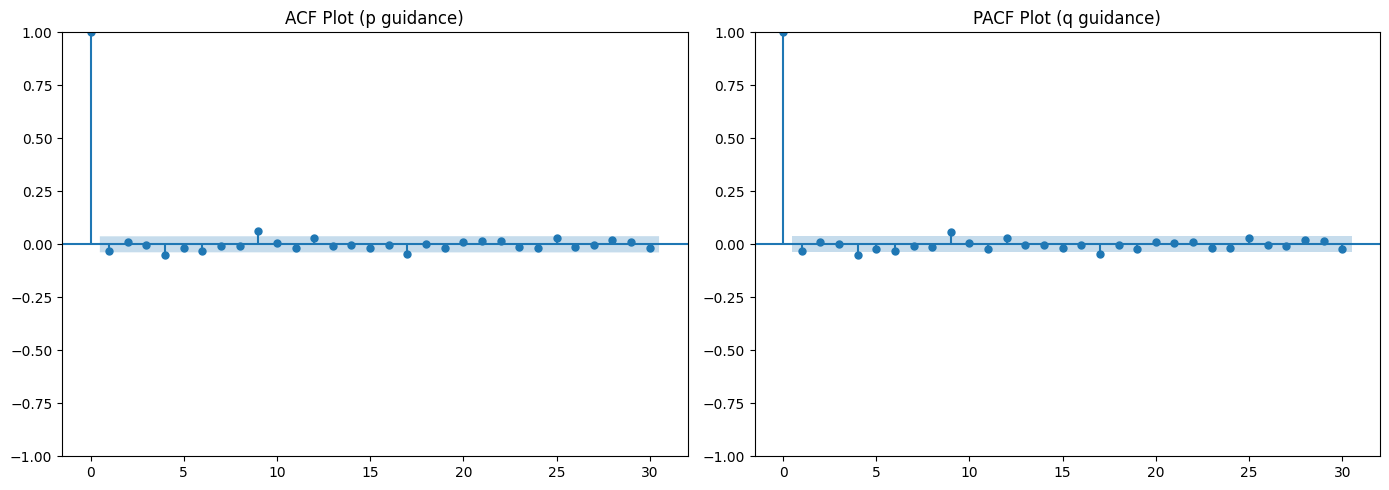

In [ ]:
# ACF and PACF Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(y_train_diff, lags=30, ax=axes[0])
axes[0].set_title("ACF Plot (p guidance)")
plot_pacf(y_train_diff, lags=30, ax=axes[1])
axes[1].set_title("PACF Plot (q guidance)")
plt.tight_layout()
plt.show()

Based on the ADF test, the raw gold price series was non-stationary,
but became stationary after first-order differencing (d=1).

The ACF plot of the differenced series showed no significant autocorrelations
after lag 0, suggesting there is no meaningful moving average component (q=0).
Similarly, the PACF plot was flat beyond lag 0, indicating no autoregressive
structure (p=0).

Together, these diagnostics support ARIMA(0,1,0) as the appropriate
baseline model — a random walk, which aligns with financial theory
(Efficient Market Hypothesis) and provides a rigorous statistical
benchmark for comparison against LSTMs.

ARIMA(0,1,0) Static Forecast:
- Fit ARIMA(0,1,0) on the training set only.
- Forecast the entire test horizon in one shot.
- This provides a clean, fair benchmark for LSTM models,
  since both are evaluated on the same test period.

In [ ]:
# Fit ARIMA(0,1,0) on training set
arima_model_static = ARIMA(y_train_usd, order=(0, 1, 0))
arima_result_static = arima_model_static.fit()

# Forecast the entire test horizon
arima_preds_static = arima_result_static.forecast(steps=len(y_test_usd))


In [ ]:
# Evaluate Static ARIMA
arima_metrics_static = {
    "R²": r2_score(y_test_usd, arima_preds_static),
    "RMSE": root_mean_squared_error(y_test_usd, arima_preds_static),
    "MAPE": mean_absolute_percentage_error(y_test_usd, arima_preds_static)
}

print("\nStatic ARIMA(0,1,0) Results (Benchmark):")
for k, v in arima_metrics_static.items():
    print(f"{k}: {v:.4f}")


Static ARIMA(0,1,0) Results (Benchmark):
R²: -0.6010
RMSE: 124.0129
MAPE: 5.1942


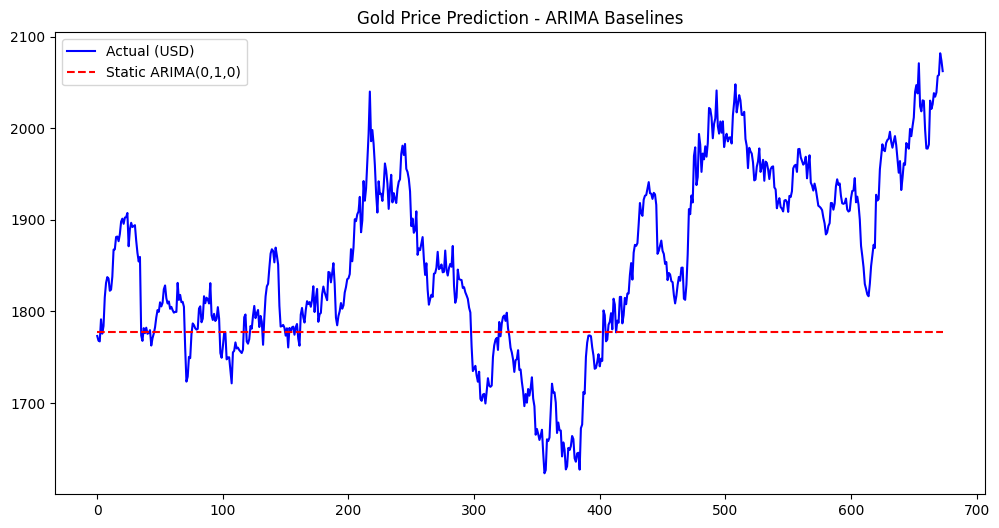

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_usd, label="Actual (USD)", color="blue")
plt.plot(arima_preds_static, label="Static ARIMA(0,1,0)", color="red", linestyle="--")
plt.title("Gold Price Prediction - ARIMA Baselines")
plt.legend()
plt.show()

In [ ]:
# Creating LSTM with Attention
import torch
import torch.nn as nn
import torch.optim as optim

# creating attention component
class Attention(nn.Module):
    """
    Custom Attention Layer for LSTM outputs.

    This layer computes attention weights over the sequence of hidden states
    and generates a weighted context vector.

    Args:
        hidden_size (int): Dimensionality of the LSTM hidden state.

    Forward Input:
        x (Tensor): LSTM output sequence of shape (batch_size, seq_len, hidden_size).

    Forward Output:
        context (Tensor): Weighted sum of hidden states, shape (batch_size, hidden_size).
        weights (Tensor): Attention weights for each time step, shape (batch_size, seq_len, 1).
    """
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        # linear layer to produce attention scores
        self.attention = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
        energy = torch.tanh(self.attention(x))             # (batch, seq_len, hidden_size)
        weights = torch.softmax(self.v(energy), dim=1)  # (batch, seq_len, 1)
        context = torch.sum(weights * x, dim=1)       # (batch, hidden_size)
        return context, weights

# creating LSTM Model with Attention
class LSTMWithAttention(nn.Module):
    """
    LSTM model with an Attention mechanism for time-series forecasting.

    Args:
        input_size (int): Number of input features.
        hidden_size (int): Dimensionality of LSTM hidden state.
        num_layers (int): Number of stacked LSTM layers.
        dropout (float): Dropout probability between layers.

    Forward Input:
        x (Tensor): Input sequence of shape (batch_size, seq_len, input_size).

    Forward Output:
        out (Tensor): Predicted value, shape (batch_size, 1).
        weights (Tensor): Attention weights, shape (batch_size, seq_len, 1).
    """

    #setting the hyperparameter default values
    def __init__(self, input_size=9, hidden_size=50, num_layers=2, dropout=0):
        super(LSTMWithAttention, self).__init__()
        #lstm layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # attention layer
        self.attention = Attention(hidden_size)
        # fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)

    # conducting the forward pass
    def forward(self, x):
        out, _ = self.lstm(x)                    # (batch, seq_len, hidden_size)
        context, weights = self.attention(out)   # (batch, hidden_size), (batch, seq_len, 1)
        out = torch.relu(context)
        out = self.fc(context)                   # (batch, 1)
        return out, weights


In [ ]:
# Creating Stacked LSTM
class StackedLSTM(nn.Module):
    """
    Standard stacked LSTM for time-series forecasting.

    Args:
        input_size (int): Number of input features.
        hidden_size (int): Dimensionality of LSTM hidden state.
        num_layers (int): Number of stacked LSTM layers.

    Forward Input:
        x (Tensor): Input sequence of shape (batch_size, seq_len, input_size).

    Forward Output:
        out (Tensor): Predicted value, shape (batch_size, 1).
    """

    def __init__(self, input_size, hidden_size, num_layers):
        super(StackedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # (batch, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])  # output only the last time step
        return out                    # (batch, 1)

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test,
                       epochs=50, lr=0.001, batch_size=32):

    """
    Train and evaluate a given PyTorch model.

    Args:
        model (torch.nn.Module): The model to train (LSTM, LSTM+Attention, etc.).
        X_train (Tensor): Training features, shape (n_samples, seq_len, n_features).
        y_train (Tensor): Training labels, shape (n_samples, 1).
        X_test (Tensor): Testing features, shape (n_samples, seq_len, n_features).
        y_test (Tensor): Testing labels, shape (n_samples, 1).
        epochs (int): Number of training epochs.
        lr (float): Learning rate for Adam optimizer.
        batch_size (int): Mini-batch size for training.

    Returns:
        tuple:
            - y_pred (np.ndarray): Model predictions on the test set.
            - metrics (dict): Dictionary of evaluation metrics (R², RMSE, MAPE).
            - attn_weights (Tensor or None): Attention weights if available, else None.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    train_losses = []  # store avg loss each epoch

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)

            # handle models differently
            if isinstance(outputs, tuple):   # attention LSTM
                preds, _ = outputs
            else:                            # stacked LSTM
                preds = outputs

            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(X_train)
        train_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")

    # plot training curve
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, marker='o', color='blue')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        if isinstance(outputs, tuple):
            preds, attn_weights = outputs
        else:
            preds, attn_weights = outputs, None
        preds = preds.cpu().numpy()

    y_true = y_test.cpu().numpy().flatten()
    y_pred = preds.flatten()

    metrics = {
        "R²": r2_score(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

    return y_pred, metrics, attn_weights


In [ ]:
# X_train, y_train, X_test, y_test should already be numpy arrays
# with shape: X = (samples, seq_len, features), y = (samples,)

input_size = X_train.shape[2]
hidden_size = 100
num_layers = 3
epochs = 100

Epoch 1/100, Avg Loss: 0.001201
Epoch 2/100, Avg Loss: 0.001150
Epoch 3/100, Avg Loss: 0.000981
Epoch 4/100, Avg Loss: 0.000607
Epoch 5/100, Avg Loss: 0.000245
Epoch 6/100, Avg Loss: 0.000302
Epoch 7/100, Avg Loss: 0.000262
Epoch 8/100, Avg Loss: 0.000173
Epoch 9/100, Avg Loss: 0.000147
Epoch 10/100, Avg Loss: 0.000133
Epoch 11/100, Avg Loss: 0.000127
Epoch 12/100, Avg Loss: 0.000124
Epoch 13/100, Avg Loss: 0.000121
Epoch 14/100, Avg Loss: 0.000117
Epoch 15/100, Avg Loss: 0.000112
Epoch 16/100, Avg Loss: 0.000106
Epoch 17/100, Avg Loss: 0.000101
Epoch 18/100, Avg Loss: 0.000096
Epoch 19/100, Avg Loss: 0.000092
Epoch 20/100, Avg Loss: 0.000088
Epoch 21/100, Avg Loss: 0.000085
Epoch 22/100, Avg Loss: 0.000082
Epoch 23/100, Avg Loss: 0.000079
Epoch 24/100, Avg Loss: 0.000077
Epoch 25/100, Avg Loss: 0.000074
Epoch 26/100, Avg Loss: 0.000072
Epoch 27/100, Avg Loss: 0.000069
Epoch 28/100, Avg Loss: 0.000068
Epoch 29/100, Avg Loss: 0.000065
Epoch 30/100, Avg Loss: 0.000064
Epoch 31/100, Avg L

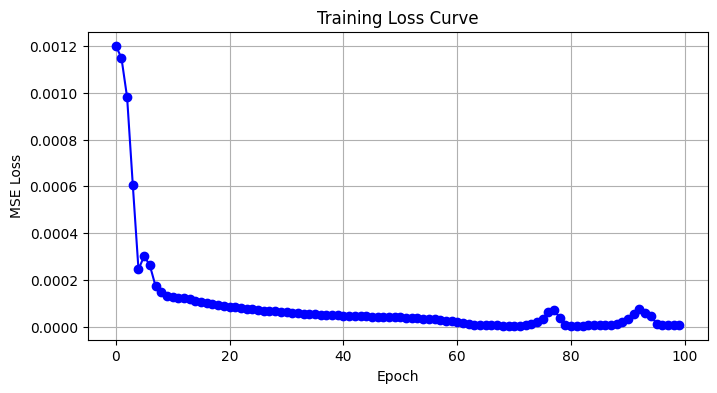

In [ ]:
# Training Stacked LSTM
stacked_model = StackedLSTM(input_size, hidden_size, num_layers)
stacked_preds, stacked_metrics, _ = train_and_evaluate(
    stacked_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    epochs=epochs, lr=0.001, batch_size=64
)

Epoch 1/100, Avg Loss: 0.001258
Epoch 2/100, Avg Loss: 0.001140
Epoch 3/100, Avg Loss: 0.001043
Epoch 4/100, Avg Loss: 0.000892
Epoch 5/100, Avg Loss: 0.000745
Epoch 6/100, Avg Loss: 0.000454
Epoch 7/100, Avg Loss: 0.000553
Epoch 8/100, Avg Loss: 0.000328
Epoch 9/100, Avg Loss: 0.000439
Epoch 10/100, Avg Loss: 0.000264
Epoch 11/100, Avg Loss: 0.000346
Epoch 12/100, Avg Loss: 0.000255
Epoch 13/100, Avg Loss: 0.000283
Epoch 14/100, Avg Loss: 0.000243
Epoch 15/100, Avg Loss: 0.000245
Epoch 16/100, Avg Loss: 0.000228
Epoch 17/100, Avg Loss: 0.000221
Epoch 18/100, Avg Loss: 0.000213
Epoch 19/100, Avg Loss: 0.000204
Epoch 20/100, Avg Loss: 0.000198
Epoch 21/100, Avg Loss: 0.000190
Epoch 22/100, Avg Loss: 0.000185
Epoch 23/100, Avg Loss: 0.000179
Epoch 24/100, Avg Loss: 0.000173
Epoch 25/100, Avg Loss: 0.000168
Epoch 26/100, Avg Loss: 0.000164
Epoch 27/100, Avg Loss: 0.000160
Epoch 28/100, Avg Loss: 0.000156
Epoch 29/100, Avg Loss: 0.000152
Epoch 30/100, Avg Loss: 0.000148
Epoch 31/100, Avg L

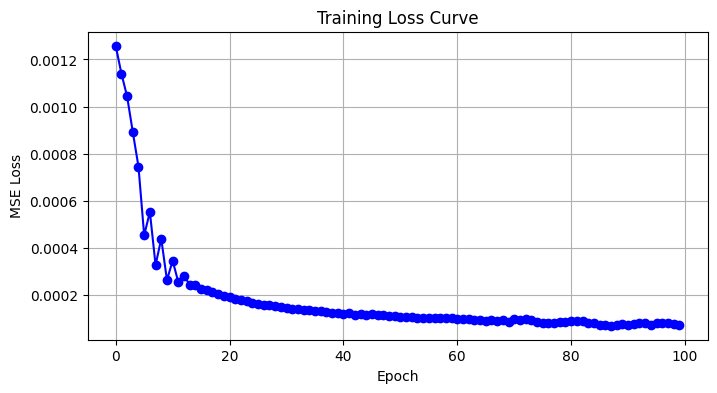

In [ ]:
# Training LSTM with Attention
attn_model = LSTMWithAttention(input_size, hidden_size, num_layers, dropout=0.2)
attn_preds, attn_metrics, attn_weights = train_and_evaluate(
    attn_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    epochs=epochs, lr=0.001, batch_size=64
)


Comparison Table:
  Metric  ARIMA(0,1,0)  Stacked LSTM  LSTM + Attention
0     R²     -0.600985      0.887192          0.234756
1   RMSE    124.012891      0.031926          0.083152
2   MAPE      5.194218      3.275762          8.155148


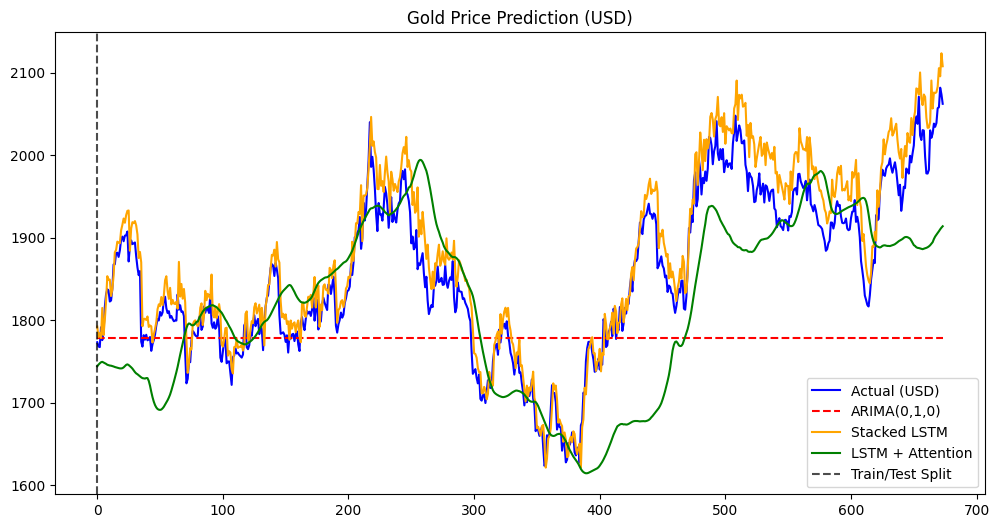

In [ ]:
results = pd.DataFrame({
    "Metric": ["R²", "RMSE", "MAPE"],
    "ARIMA(0,1,0)": [arima_metrics_static["R²"], arima_metrics_static["RMSE"], arima_metrics_static["MAPE"]],
    "Stacked LSTM": [stacked_metrics["R²"], stacked_metrics["RMSE"], stacked_metrics["MAPE"]],
    "LSTM + Attention": [attn_metrics["R²"], attn_metrics["RMSE"], attn_metrics["MAPE"]]
})
print("\nComparison Table:")
print(results)

# Inverse transform predictions + actuals
stacked_preds_usd = scaler_close.inverse_transform(stacked_preds.reshape(-1,1)).flatten()
attn_preds_usd = scaler_close.inverse_transform(attn_preds.reshape(-1,1)).flatten()
y_test_usd = scaler_close.inverse_transform(y_test.reshape(-1,1)).flatten()

# Plot Actual vs Predictions
plt.figure(figsize=(12,6))
plt.plot(y_test_usd, label="Actual (USD)", color="blue")
plt.plot(arima_preds_static, label="ARIMA(0,1,0)", color="red", linestyle="--")
plt.plot(stacked_preds_usd, label="Stacked LSTM", color="orange")
plt.plot(attn_preds_usd, label="LSTM + Attention", color="green")

split_index = len(y_train_usd)  # boundary index
plt.axvline(x=0, color="black", linestyle="--", alpha=0.7, label="Train/Test Split")

plt.title("Gold Price Prediction (USD)")
plt.legend()
plt.show()

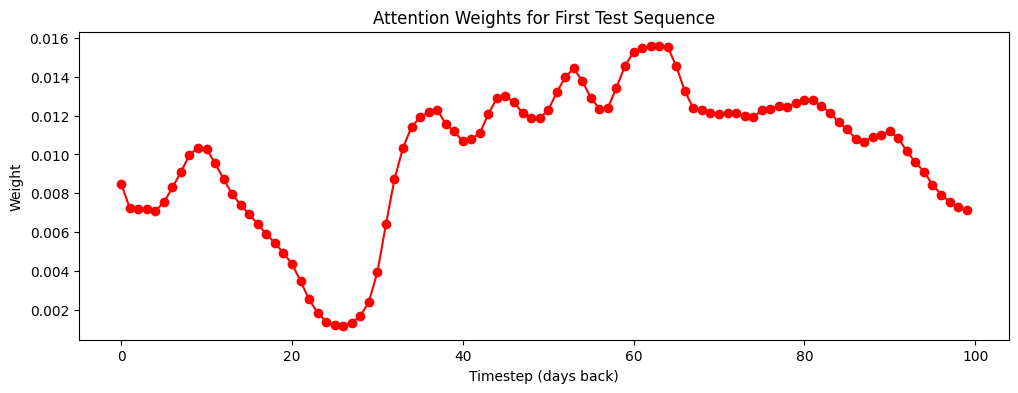

In [ ]:
if attn_weights is not None:
    attn_weights = attn_weights.squeeze().cpu().numpy()  # (batch, seq_len)
    plt.figure(figsize=(12, 4))
    plt.plot(attn_weights[0], marker='o', color='red')
    plt.title("Attention Weights for First Test Sequence")
    plt.xlabel("Timestep (days back)")
    plt.ylabel("Weight")
    plt.show()

In [ ]:
# -------------------------
# Get Training Predictions
# -------------------------

# Stacked LSTM predictions on training data
stacked_train_preds = stacked_model(X_train_tensor).detach().cpu().numpy().flatten()
stacked_train_preds_usd = scaler_close.inverse_transform(stacked_train_preds.reshape(-1,1)).flatten()

# Attention LSTM predictions on training data
attn_output = attn_model(X_train_tensor)        # returns (preds, attention_weights)
attn_train_preds = attn_output[0].detach().cpu().numpy().flatten()  # take preds only
attn_train_preds_usd = scaler_close.inverse_transform(attn_train_preds.reshape(-1,1)).flatten()

# Actual training values (inverse transformed)
y_train_usd = scaler_close.inverse_transform(y_train.reshape(-1,1)).flatten()

In [ ]:
# -------------------------
# Training Metrics
# -------------------------
stacked_train_metrics = {
    "R²": r2_score(y_train_usd, stacked_train_preds_usd),
    "RMSE": root_mean_squared_error(y_train_usd, stacked_train_preds_usd),
    "MAPE": mean_absolute_percentage_error(y_train_usd, stacked_train_preds_usd)
}

attn_train_metrics = {
    "R²": r2_score(y_train_usd, attn_train_preds_usd),
    "RMSE": root_mean_squared_error(y_train_usd, attn_train_preds_usd),
    "MAPE": mean_absolute_percentage_error(y_train_usd, attn_train_preds_usd)
}

print("\nStacked LSTM Training Metrics:", stacked_train_metrics)
print("LSTM + Attention Training Metrics:", attn_train_metrics)



Stacked LSTM Training Metrics: {'R²': 0.983850599691419, 'RMSE': np.float64(27.963399266731493), 'MAPE': np.float64(1.7474086527784618)}
LSTM + Attention Training Metrics: {'R²': 0.9106939792962924, 'RMSE': np.float64(65.75853557079074), 'MAPE': np.float64(3.9135604946429834)}


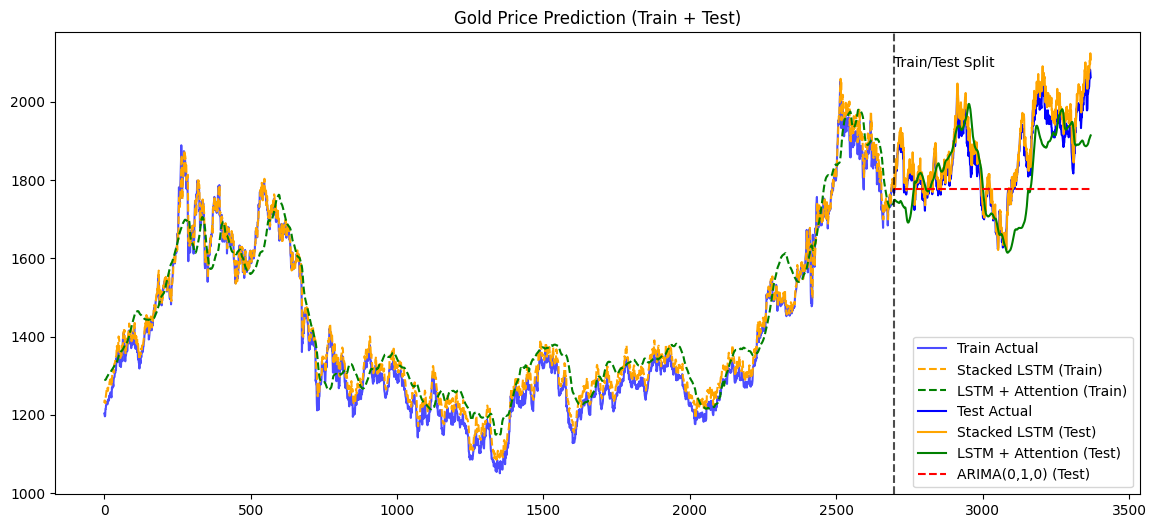

In [ ]:
# -------------------------
# Plot Full Series (Train + Test)
# -------------------------
plt.figure(figsize=(14,6))

# Training portion
plt.plot(range(len(y_train_usd)), y_train_usd, label="Train Actual", color="blue", alpha=0.7)
plt.plot(range(len(y_train_usd)), stacked_train_preds_usd, label="Stacked LSTM (Train)", color="orange", linestyle="--")
plt.plot(range(len(y_train_usd)), attn_train_preds_usd, label="LSTM + Attention (Train)", color="green", linestyle="--")

# Test portion
plt.plot(range(len(y_train_usd), len(y_train_usd)+len(y_test_usd)), y_test_usd, label="Test Actual", color="blue")
plt.plot(range(len(y_train_usd), len(y_train_usd)+len(y_test_usd)), stacked_preds_usd, label="Stacked LSTM (Test)", color="orange")
plt.plot(range(len(y_train_usd), len(y_train_usd)+len(y_test_usd)), attn_preds_usd, label="LSTM + Attention (Test)", color="green")
plt.plot(range(len(y_train_usd), len(y_train_usd)+len(y_test_usd)), arima_preds_static, label="ARIMA(0,1,0) (Test)", color="red", linestyle="--")

# Mark the train/test split
plt.axvline(x=len(y_train_usd), color="black", linestyle="--", alpha=0.7)
plt.text(len(y_train_usd), max(np.concatenate([y_train_usd,y_test_usd])), "Train/Test Split",
         verticalalignment="bottom", horizontalalignment="left", fontsize=10, color="black")

plt.title("Gold Price Prediction (Train + Test)")
plt.legend()
plt.show()
